#### Loading the noshowappointments dataset from Kaggle and loading it onto a Pandas dataframe

In [147]:
import kagglehub
path = kagglehub.dataset_download("joniarroba/noshowappointments")
print("path to dataset files -> {}".format(path))

Using Colab cache for faster access to the 'noshowappointments' dataset.
path to dataset files -> /kaggle/input/noshowappointments


In [148]:
import os
print(os.listdir(path))

['KaggleV2-May-2016.csv']


In [149]:
import pandas as pd
files = os.listdir(path)
csv_file = [f for f in files if f.endswith('.csv')][0]
fullpath = os.path.join(path, csv_file)
noshow_dataset_df = pd.read_csv(fullpath)

#### Data exploratrion

In [150]:
noshow_dataset_df.head(4)

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No


In [151]:
noshow_dataset_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   PatientId       110527 non-null  float64
 1   AppointmentID   110527 non-null  int64  
 2   Gender          110527 non-null  object 
 3   ScheduledDay    110527 non-null  object 
 4   AppointmentDay  110527 non-null  object 
 5   Age             110527 non-null  int64  
 6   Neighbourhood   110527 non-null  object 
 7   Scholarship     110527 non-null  int64  
 8   Hipertension    110527 non-null  int64  
 9   Diabetes        110527 non-null  int64  
 10  Alcoholism      110527 non-null  int64  
 11  Handcap         110527 non-null  int64  
 12  SMS_received    110527 non-null  int64  
 13  No-show         110527 non-null  object 
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


In [152]:
noshow_dataset_df.describe()

,PatientId,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
count,1.105270e+05,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474963e+14,5.675305e+06,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026
std,2.560949e+14,7.129575e+04,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873
min,3.921784e+04,5.030230e+06,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.172614e+12,5.640286e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.173184e+13,5.680573e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.439172e+13,5.725524e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


#### Removal of features than cannot affect the outcome(i.e., whether the patient is a no show) in any way

In [153]:
noshow_dataset_df1 = noshow_dataset_df.drop(['PatientId', 'AppointmentID'], axis=1)

In [154]:
noshow_dataset_df1.describe()

,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
count,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026
std,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873
min,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


In [155]:
noshow_dataset_df1.head()

,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [156]:
noshow_dataset_df1.tail(100)

,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
110427,F,2016-06-02T09:46:11Z,2016-06-08T00:00:00Z,56,RESISTÊNCIA,0,0,0,0,0,1,No
110428,F,2016-06-03T12:33:46Z,2016-06-08T00:00:00Z,8,RESISTÊNCIA,0,0,0,0,0,1,Yes
110429,F,2016-06-07T10:12:25Z,2016-06-08T00:00:00Z,44,RESISTÊNCIA,0,0,0,0,0,0,Yes
110430,F,2016-05-25T09:01:33Z,2016-06-01T00:00:00Z,57,RESISTÊNCIA,0,0,0,0,0,0,Yes
110431,M,2016-06-03T08:45:25Z,2016-06-08T00:00:00Z,12,RESISTÊNCIA,0,0,0,0,0,1,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...
110522,F,2016-05-03T09:15:35Z,2016-06-07T00:00:00Z,56,MARIA ORTIZ,0,0,0,0,0,1,No
110523,F,2016-05-03T07:27:33Z,2016-06-07T00:00:00Z,51,MARIA ORTIZ,0,0,0,0,0,1,No
110524,F,2016-04-27T16:03:52Z,2016-06-07T00:00:00Z,21,MARIA ORTIZ,0,0,0,0,0,1,No
110525,F,2016-04-27T15:09:23Z,2016-06-07T00:00:00Z,38,MARIA ORTIZ,0,0,0,0,0,1,No


## converting all the columns to numeric datatypes

male values denoted by 'M' in the Gender column are encoded as 0 and female → 'F' encoded as 1

In [157]:
noshow_dataset_df1['Gender'] = noshow_dataset_df1['Gender'].apply(lambda x: 1 if x == 'F' else 0)

In [158]:
noshow_dataset_df1.keys()

Index(['Gender', 'ScheduledDay', 'AppointmentDay', 'Age', 'Neighbourhood',
       'Scholarship', 'Hipertension', 'Diabetes', 'Alcoholism', 'Handcap',
       'SMS_received', 'No-show'],
      dtype='object')

Encoding of the No-show column:
 'Yes' encoded as 1
 'No' encoded as 0

In [159]:
noshow_dataset_df1['No-show'] = noshow_dataset_df1['No-show'].apply(lambda x: 1 if x == 'Yes' else 0)

In [160]:
noshow_dataset_df1.describe()

,Gender,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
count,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,0.649977,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026,0.201933
std,0.476979,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873,0.401444
min,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000,1.000000


In [161]:
noshow_dataset_df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   Gender          110527 non-null  int64 
 1   ScheduledDay    110527 non-null  object
 2   AppointmentDay  110527 non-null  object
 3   Age             110527 non-null  int64 
 4   Neighbourhood   110527 non-null  object
 5   Scholarship     110527 non-null  int64 
 6   Hipertension    110527 non-null  int64 
 7   Diabetes        110527 non-null  int64 
 8   Alcoholism      110527 non-null  int64 
 9   Handcap         110527 non-null  int64 
 10  SMS_received    110527 non-null  int64 
 11  No-show         110527 non-null  int64 
dtypes: int64(9), object(3)
memory usage: 10.1+ MB


In [162]:
noshow_dataset_df1[['ScheduledDay', 'AppointmentDay']].tail(100)

,ScheduledDay,AppointmentDay
110427,2016-06-02T09:46:11Z,2016-06-08T00:00:00Z
110428,2016-06-03T12:33:46Z,2016-06-08T00:00:00Z
110429,2016-06-07T10:12:25Z,2016-06-08T00:00:00Z
110430,2016-05-25T09:01:33Z,2016-06-01T00:00:00Z
110431,2016-06-03T08:45:25Z,2016-06-08T00:00:00Z
...,...,...
110522,2016-05-03T09:15:35Z,2016-06-07T00:00:00Z
110523,2016-05-03T07:27:33Z,2016-06-07T00:00:00Z
110524,2016-04-27T16:03:52Z,2016-06-07T00:00:00Z
110525,2016-04-27T15:09:23Z,2016-06-07T00:00:00Z


## Feature engineering

In the cell below, the duration, in days, between schedule day and appointment day is derived and stored in a column

In [163]:
noshow_dataset_df1[['AppointmentDay', 'ScheduledDay']] = noshow_dataset_df1[['AppointmentDay', 'ScheduledDay']].apply(pd.to_datetime)
noshow_dataset_df1['WaitingDays'] = (noshow_dataset_df1['AppointmentDay'] - noshow_dataset_df1['ScheduledDay']).dt.days

In [164]:
noshow_dataset_df1['WaitingDays'].head(10000)

,WaitingDays
0,-1
1,-1
2,-1
3,-1
4,-1
...,...
9995,-1
9996,-1
9997,5
9998,5


In [165]:
negative_wait = noshow_dataset_df1[noshow_dataset_df1['WaitingDays'] < 0]
print(f"Records with negative waiting time: {len(negative_wait)}")
print(f"Percentage of total: {len(negative_wait)/len(noshow_dataset_df1)*100:.2f}%")

Records with negative waiting time: 38568
Percentage of total: 34.89%


In [166]:
noshow_dataset_df1[noshow_dataset_df1['WaitingDays'] == -1].sample(n=10, replace=True)

,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,WaitingDays
101520,0,2016-06-01 08:47:29+00:00,2016-06-01 00:00:00+00:00,63,SANTA MARTHA,0,0,0,1,0,0,0,-1
91255,0,2016-06-02 09:41:17+00:00,2016-06-02 00:00:00+00:00,72,MARIA ORTIZ,0,0,0,0,0,0,0,-1
50073,1,2016-05-02 09:05:39+00:00,2016-05-02 00:00:00+00:00,2,JARDIM DA PENHA,0,0,0,0,0,0,0,-1
34295,1,2016-05-04 08:12:59+00:00,2016-05-04 00:00:00+00:00,26,REDENÇÃO,0,0,0,0,0,0,0,-1
108537,0,2016-06-03 08:49:08+00:00,2016-06-03 00:00:00+00:00,0,DO CABRAL,0,0,0,0,0,0,0,-1
92594,1,2016-06-08 15:29:13+00:00,2016-06-08 00:00:00+00:00,46,JARDIM CAMBURI,0,0,0,0,0,0,0,-1
7494,0,2016-05-10 14:32:23+00:00,2016-05-10 00:00:00+00:00,46,JABOUR,0,0,0,0,0,0,0,-1
76190,1,2016-05-17 13:48:42+00:00,2016-05-17 00:00:00+00:00,16,JARDIM CAMBURI,1,0,0,0,0,0,1,-1
61297,1,2016-05-05 07:59:00+00:00,2016-05-05 00:00:00+00:00,29,MARIA ORTIZ,0,0,0,0,0,0,0,-1
79951,0,2016-05-03 08:25:45+00:00,2016-05-03 00:00:00+00:00,81,PRAIA DO CANTO,0,1,1,0,0,0,0,-1


In [167]:
noshow_dataset_df1[(noshow_dataset_df1['WaitingDays'] == -1) & (noshow_dataset_df1['No-show'] == 1)].sample(n=5)

,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,WaitingDays
95205,0,2016-06-08 07:56:03+00:00,2016-06-08 00:00:00+00:00,13,CARATOÍRA,0,0,0,0,0,0,1,-1
71781,1,2016-05-19 13:43:43+00:00,2016-05-19 00:00:00+00:00,73,PRAIA DO CANTO,0,1,1,0,0,0,1,-1
92714,1,2016-06-01 14:14:43+00:00,2016-06-01 00:00:00+00:00,26,RESISTÊNCIA,0,0,0,0,0,0,1,-1
78029,1,2016-05-17 09:06:11+00:00,2016-05-17 00:00:00+00:00,17,SANTA MARTHA,1,0,0,0,0,0,1,-1
95339,1,2016-06-01 09:41:24+00:00,2016-06-01 00:00:00+00:00,7,MARIA ORTIZ,0,0,0,0,0,0,1,-1


In [168]:
print(len(noshow_dataset_df[(noshow_dataset_df1['WaitingDays'] == -1) & (noshow_dataset_df1['No-show'] == 1)])/ len(negative_wait) * 100)

4.646338933831156


some statistics,
    37% of records show negative waiting times
    of that 4% are no show appointments
conclusion:
    initially thought negative waiting times are a proxy for walk-in appointments, however, 4% no show subset disproves this, and
    now it is assumed that they are errors in data collections.

### issuing an integer id for each unique neighborhood

In [169]:
print(noshow_dataset_df1['Neighbourhood'].nunique())

81


80 unique neighborhoods to be converted into 80 integer ids

In [170]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
noshow_dataset_df1['Neighbourhood'] = le.fit_transform(noshow_dataset_df1['Neighbourhood'])
print("Neighbourhood lookup table:\n")
for i,class_name in enumerate(le.classes_):
    print("ID: {}, Neighborhood name: {}".format(i, class_name))

Neighbourhood lookup table:

ID: 0, Neighborhood name: AEROPORTO
ID: 1, Neighborhood name: ANDORINHAS
ID: 2, Neighborhood name: ANTÔNIO HONÓRIO
ID: 3, Neighborhood name: ARIOVALDO FAVALESSA
ID: 4, Neighborhood name: BARRO VERMELHO
ID: 5, Neighborhood name: BELA VISTA
ID: 6, Neighborhood name: BENTO FERREIRA
ID: 7, Neighborhood name: BOA VISTA
ID: 8, Neighborhood name: BONFIM
ID: 9, Neighborhood name: CARATOÍRA
ID: 10, Neighborhood name: CENTRO
ID: 11, Neighborhood name: COMDUSA
ID: 12, Neighborhood name: CONQUISTA
ID: 13, Neighborhood name: CONSOLAÇÃO
ID: 14, Neighborhood name: CRUZAMENTO
ID: 15, Neighborhood name: DA PENHA
ID: 16, Neighborhood name: DE LOURDES
ID: 17, Neighborhood name: DO CABRAL
ID: 18, Neighborhood name: DO MOSCOSO
ID: 19, Neighborhood name: DO QUADRO
ID: 20, Neighborhood name: ENSEADA DO SUÁ
ID: 21, Neighborhood name: ESTRELINHA
ID: 22, Neighborhood name: FONTE GRANDE
ID: 23, Neighborhood name: FORTE SÃO JOÃO
ID: 24, Neighborhood name: FRADINHOS
ID: 25, Neighborhoo

In [171]:
noshow_dataset_df1.head(5)

,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,WaitingDays
0,1,2016-04-29 18:38:08+00:00,2016-04-29 00:00:00+00:00,62,39,0,1,0,0,0,0,0,-1
1,0,2016-04-29 16:08:27+00:00,2016-04-29 00:00:00+00:00,56,39,0,0,0,0,0,0,0,-1
2,1,2016-04-29 16:19:04+00:00,2016-04-29 00:00:00+00:00,62,45,0,0,0,0,0,0,0,-1
3,1,2016-04-29 17:29:31+00:00,2016-04-29 00:00:00+00:00,8,54,0,0,0,0,0,0,0,-1
4,1,2016-04-29 16:07:23+00:00,2016-04-29 00:00:00+00:00,56,39,0,1,1,0,0,0,0,-1


extracting the day of the week and month for the appointment

In [172]:
noshow_dataset_df1['appointment_day_of_week'] = noshow_dataset_df1['AppointmentDay'].dt.day_name()
noshow_dataset_df1['appointment_month'] = noshow_dataset_df1['AppointmentDay'].dt.month

encoding the day of the week

In [173]:
# For KNN, you might want numerical encoding
day_mapping = {'Monday': 0, 'Tuesday': 1, 'Wednesday': 2, 'Thursday': 3,
               'Friday': 4, 'Saturday': 5, 'Sunday': 6}
noshow_dataset_df1['day_of_week_encoded'] = noshow_dataset_df1['appointment_day_of_week'].map(day_mapping)

In [174]:
noshow_dataset_df1['appointment_month'].sample(10000)

,appointment_month
77442,5
59611,5
110191,6
15381,5
99862,6
...,...
67129,5
710,4
79942,5
84671,6


In [175]:
noshow_dataset_df1[['appointment_month','AppointmentDay']].sample(20)

,appointment_month,AppointmentDay
30445,5,2016-05-30 00:00:00+00:00
86942,6,2016-06-01 00:00:00+00:00
28756,5,2016-05-02 00:00:00+00:00
5506,5,2016-05-17 00:00:00+00:00
6368,5,2016-05-20 00:00:00+00:00
48651,5,2016-05-19 00:00:00+00:00
92212,6,2016-06-07 00:00:00+00:00
94189,6,2016-06-06 00:00:00+00:00
103212,6,2016-06-03 00:00:00+00:00
53061,5,2016-05-25 00:00:00+00:00


### adding the hypertension vs age feature interaction

In [176]:
noshow_dataset_df1["age_hypertension_interraction"] = noshow_dataset_df1["Age"] * noshow_dataset_df1["Hipertension"]

creating a feature for if the appointment day is a weekend

In [177]:
noshow_dataset_df1["is_weekend"] = noshow_dataset_df1["day_of_week_encoded"].apply(lambda x: 1 if (x == 5) or (x == 6) else 0)

In [178]:
noshow_dataset_df1[noshow_dataset_df1["is_weekend"] == 1].count()

,0
Gender,39
ScheduledDay,39
AppointmentDay,39
Age,39
Neighbourhood,39
Scholarship,39
Hipertension,39
Diabetes,39
Alcoholism,39
Handcap,39


adding is_Friday boolean feature to the data

In [179]:
noshow_dataset_df1["is_friday"] = noshow_dataset_df1["day_of_week_encoded"].apply(lambda x: 1 if x == 4 else 0)
noshow_dataset_df1[(noshow_dataset_df1["is_friday"] == 1)].sample(10)

,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,WaitingDays,appointment_day_of_week,appointment_month,day_of_week_encoded,age_hypertension_interraction,is_weekend,is_friday
12830,0,2016-05-20 08:55:35+00:00,2016-05-20 00:00:00+00:00,58,43,0,0,0,0,0,0,0,-1,Friday,5,4,0,0,1
62969,1,2016-03-03 10:38:32+00:00,2016-05-20 00:00:00+00:00,68,38,0,0,0,0,0,0,1,77,Friday,5,4,0,0,1
2238,1,2016-04-29 09:15:14+00:00,2016-04-29 00:00:00+00:00,59,13,0,0,0,0,0,0,0,-1,Friday,4,4,0,0,1
697,1,2016-04-29 12:45:59+00:00,2016-04-29 00:00:00+00:00,37,40,1,0,0,0,0,0,0,-1,Friday,4,4,0,0,1
7186,0,2016-05-20 09:08:29+00:00,2016-05-20 00:00:00+00:00,63,48,0,0,0,0,0,0,0,-1,Friday,5,4,0,0,1
59624,1,2016-05-09 09:51:39+00:00,2016-05-13 00:00:00+00:00,30,76,0,1,0,0,0,0,1,3,Friday,5,4,30,0,1
106333,1,2016-05-16 11:54:09+00:00,2016-06-03 00:00:00+00:00,20,70,0,0,0,0,0,1,1,17,Friday,6,4,0,0,1
57294,1,2016-05-20 07:26:30+00:00,2016-05-20 00:00:00+00:00,31,43,0,0,0,0,0,0,0,-1,Friday,5,4,0,0,1
56538,1,2016-05-06 07:49:19+00:00,2016-05-06 00:00:00+00:00,19,27,0,0,0,0,0,0,0,-1,Friday,5,4,0,0,1
428,1,2016-03-22 08:28:21+00:00,2016-04-29 00:00:00+00:00,7,36,0,0,0,0,0,1,0,37,Friday,4,4,0,0,1


age categorization

In [180]:
noshow_dataset_df1["age_group"] = pd.cut(noshow_dataset_df1["Age"],
                                         bins=[0, 12, 19, 35, 50, 65, 100],
                                         labels=['child', 'teen', 'young_adult', 'adult', 'middle_aged', 'senior'])

In [181]:
noshow_dataset_df1.sample(5)

,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,WaitingDays,appointment_day_of_week,appointment_month,day_of_week_encoded,age_hypertension_interraction,is_weekend,is_friday,age_group
100720,1,2016-06-02 13:40:43+00:00,2016-06-02 00:00:00+00:00,69,78,0,1,0,0,0,0,0,-1,Thursday,6,3,69,0,0,senior
72712,1,2016-05-19 11:41:04+00:00,2016-05-25 00:00:00+00:00,62,73,0,1,0,0,0,1,0,5,Wednesday,5,2,62,0,0,middle_aged
108736,0,2016-06-01 18:18:14+00:00,2016-06-02 00:00:00+00:00,31,46,0,0,0,0,0,0,0,0,Thursday,6,3,0,0,0,young_adult
104885,1,2016-05-12 14:03:44+00:00,2016-06-03 00:00:00+00:00,55,1,0,1,0,0,0,1,0,21,Friday,6,4,55,0,1,middle_aged
68618,0,2016-04-26 08:59:13+00:00,2016-05-10 00:00:00+00:00,7,69,1,0,0,0,0,1,1,13,Tuesday,5,1,0,0,0,child


In [182]:
age_group_dummies = pd.get_dummies(noshow_dataset_df1["age_group"], prefix='age_group', dtype=int)
age_group_dummies

,age_group_child,age_group_teen,age_group_young_adult,age_group_adult,age_group_middle_aged,age_group_senior
0,0,0,0,0,1,0
1,0,0,0,0,1,0
2,0,0,0,0,1,0
3,1,0,0,0,0,0
4,0,0,0,0,1,0
...,...,...,...,...,...,...
110522,0,0,0,0,1,0
110523,0,0,0,0,1,0
110524,0,0,1,0,0,0
110525,0,0,0,1,0,0


In [183]:
noshow_dataset_df1 = pd.concat([noshow_dataset_df1, age_group_dummies], axis=1)

In [184]:
import numpy as np
# Convert to Unix timestamp (seconds)
noshow_dataset_df1['ScheduledDay'] = noshow_dataset_df1['ScheduledDay'].astype(np.int64) // 10**9
noshow_dataset_df1['AppointmentDay'] = noshow_dataset_df1['AppointmentDay'].astype(np.int64) // 10**9


In [185]:
final_df = noshow_dataset_df1.drop(['appointment_day_of_week', 'age_group'], axis=1)
print(final_df.columns)
noshow_dataset_df1["AppointmentDay"].dtype

Index(['Gender', 'ScheduledDay', 'AppointmentDay', 'Age', 'Neighbourhood',
       'Scholarship', 'Hipertension', 'Diabetes', 'Alcoholism', 'Handcap',
       'SMS_received', 'No-show', 'WaitingDays', 'appointment_month',
       'day_of_week_encoded', 'age_hypertension_interraction', 'is_weekend',
       'is_friday', 'age_group_child', 'age_group_teen',
       'age_group_young_adult', 'age_group_adult', 'age_group_middle_aged',
       'age_group_senior'],
      dtype='object')


dtype('int64')

In [186]:
import numpy as np
# Convert to Unix timestamp (seconds)
noshow_dataset_df1['ScheduledDay'] = noshow_dataset_df1['ScheduledDay'].astype(np.int64) // 10**9
noshow_dataset_df1['AppointmentDay'] = noshow_dataset_df1['AppointmentDay'].astype(np.int64) // 10**9


In [187]:
final_df.sample(4)

,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,...,day_of_week_encoded,age_hypertension_interraction,is_weekend,is_friday,age_group_child,age_group_teen,age_group_young_adult,age_group_adult,age_group_middle_aged,age_group_senior
108184,1,1463674696,1464912000,24,6,0,0,0,0,0,...,4,0,0,1,0,0,1,0,0,0
77617,1,1464106390,1464048000,80,1,0,1,0,0,0,...,1,80,0,0,0,0,0,0,0,1
57623,0,1463489738,1463529600,54,26,0,0,1,0,0,...,2,0,0,0,0,0,0,0,1,0
65667,0,1463562251,1463529600,7,75,0,0,0,0,0,...,2,0,0,0,1,0,0,0,0,0


## Model Training and Evaluation

initial model training

In [188]:
X = final_df[['Gender', 'ScheduledDay', 'AppointmentDay', 'Age', 'Neighbourhood', 'Scholarship', 'Hipertension', 'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received', 'No-show', 'WaitingDays', 'appointment_month','day_of_week_encoded', 'age_hypertension_interraction', 'is_weekend',
       'is_friday', 'age_group_child', 'age_group_teen',
       'age_group_young_adult', 'age_group_adult', 'age_group_middle_aged',
       'age_group_senior']]
y = final_df['No-show']

In [189]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [190]:
from sklearn.neighbors import KNeighborsClassifier
kcl = KNeighborsClassifier(n_neighbors=5, n_jobs=-1, algorithm='ball_tree').fit(X_train,y_train)

In [191]:
print(kcl.score(X_test, y_test))

0.7704111175448755


parameter fine tuning
            → finding the ideal number of n_neighbours to create a model thats 70-90% accurate

Testing neighbors: 100%|██████████| 99/99 [14:47<00:00,  8.96s/it]


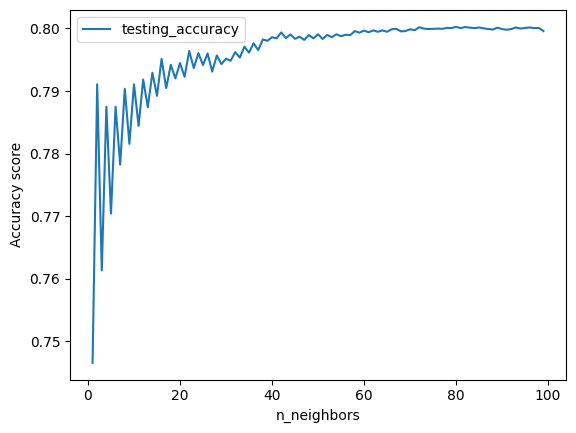

In [192]:
from tqdm import tqdm as tqdm_base
import matplotlib.pyplot as plt

testing_accuracy = []
neighbours = range(1, 100, 1)

for n in tqdm_base(neighbours, desc="Testing neighbors"):
    kcl = KNeighborsClassifier(n_neighbors=n, n_jobs=-1, algorithm="ball_tree").fit(X_train, y_train)
    acc = kcl.score(X_test, y_test)
    testing_accuracy.append(acc)

plt.plot(neighbours, testing_accuracy, label='testing_accuracy')
plt.ylabel('Accuracy score')
plt.xlabel('n_neighbors')
plt.legend()
plt.show()


In [193]:
print(testing_accuracy)

[0.7465619571511292, 0.7910755645628257, 0.7613274464389114, 0.787492762015055, 0.7704111175448755, 0.787492762015055, 0.7782281412854661, 0.7903517660683266, 0.7815576143601621, 0.7910755645628257, 0.7844166184134337, 0.7918355529820498, 0.7874203821656051, 0.7929212507237985, 0.7892298784018529, 0.7951288361320209, 0.7904603358425014, 0.794187898089172, 0.7920165026056746, 0.7944774174869716, 0.7922698320787492, 0.7963954834973943, 0.7936812391430226, 0.7960697741748697, 0.794151708164447, 0.7959973943254198, 0.7931022003474233, 0.7956716850028952, 0.7942964678633468, 0.7951650260567458, 0.7948393167342211, 0.7962145338737695, 0.7953459756803706, 0.7970830920671685, 0.7961421540243196, 0.7976259409380428, 0.7965402431962941, 0.7982411696583671, 0.7980240301100173, 0.7986030689056167, 0.7984221192819919, 0.7993630573248408, 0.7984583092067169, 0.7990373480023162, 0.798349739432542, 0.7986754487550666, 0.7981687898089171, 0.7989287782281412, 0.7984221192819919, 0.7990735379270412, 0.79